# Tonga Analysis

In [17]:
import datetime
import os
import glob # File pattern matching library

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import filtfilt, butter
from scipy import signal

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

# Control maximum number of rows Pandas can show.
pd.set_option('display.max_rows', 100)

# Load Data File and Plot Raw Data

In [20]:
# Load file into dataframe, ignore comment line,s and parse dates
data_dir = 'tonga_data'
fnames = glob.glob(os.path.join(data_dir,'*.csv.bz2'))
fnames.sort()

In [21]:
fnames

['tonga_data/2022-01-15T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000002_S1_EN91fl_FRQ_WWV2p5.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000003_G1_EN91fh_FRQ_WWV2p5.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000004_S1_EN91fl_FRQ_CHU7.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000007_G1_EN91f_FRQ_WWV10.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000008_S1_EN91fl_FRQ_WWV10.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000014_G1_FN21ei_FRQ_WWV10.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000022_G1_EN91he_FRQ_WWV10.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000024_G1_JO33kg_FRQ_CHU14.csv.bz2',
 'tonga_data/2022-01-15T000000Z_N0000030_G1_EM73sj_FRQ_WWV10.csv.bz2']

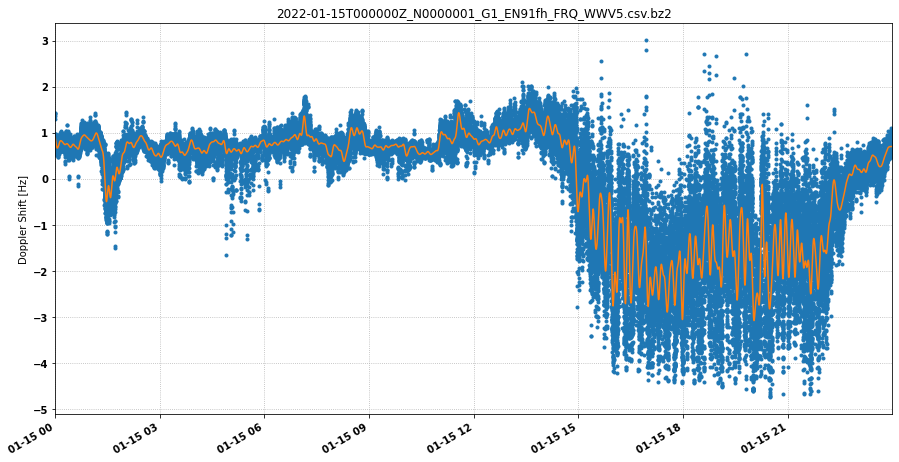

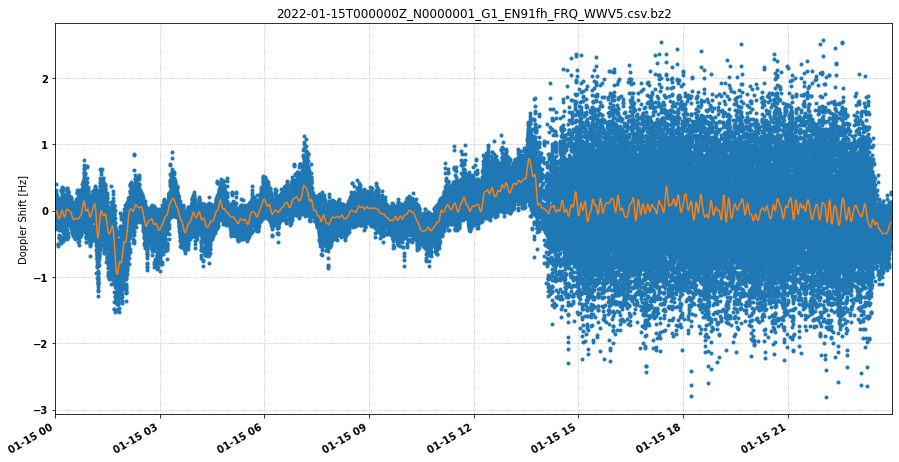

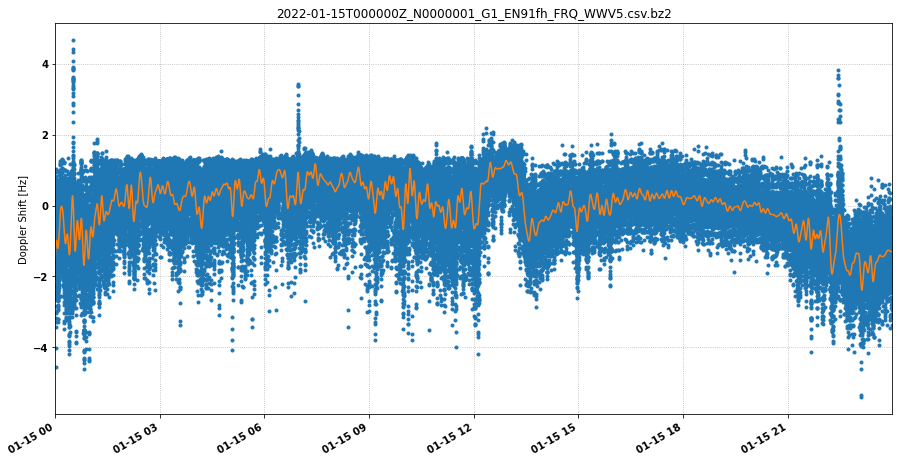

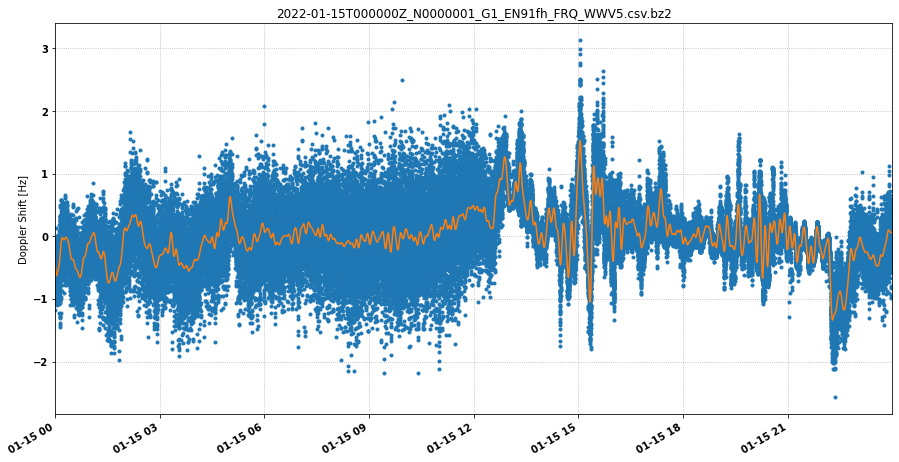

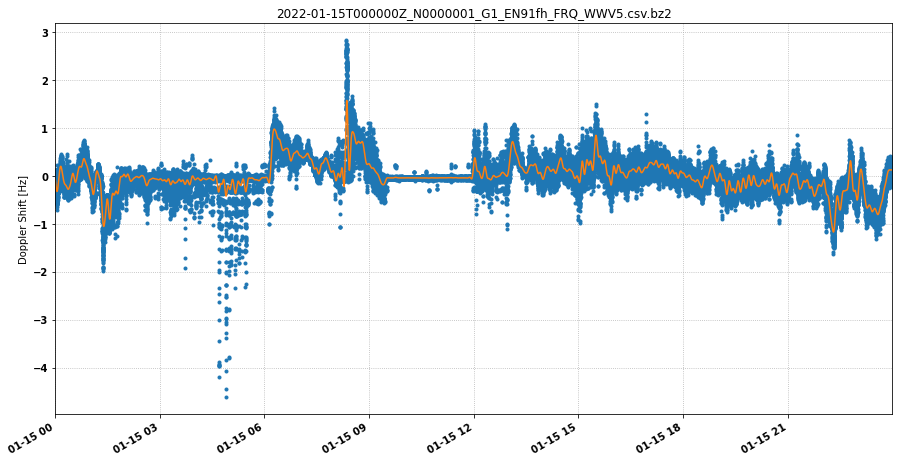

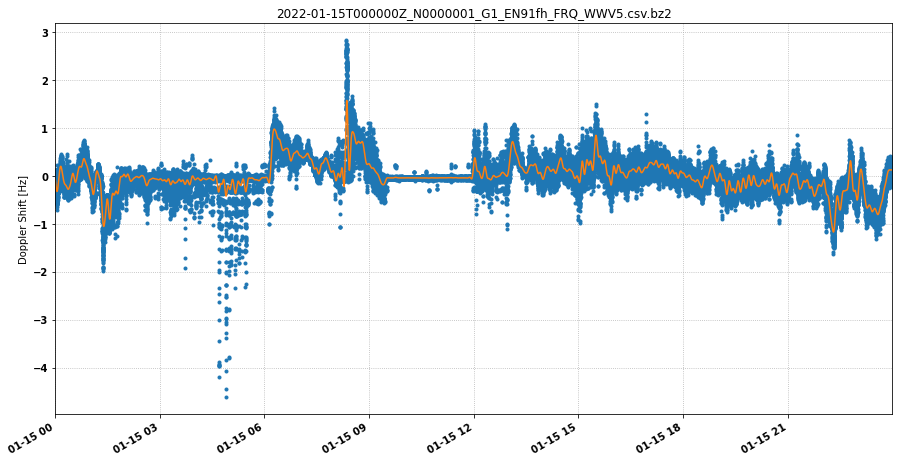

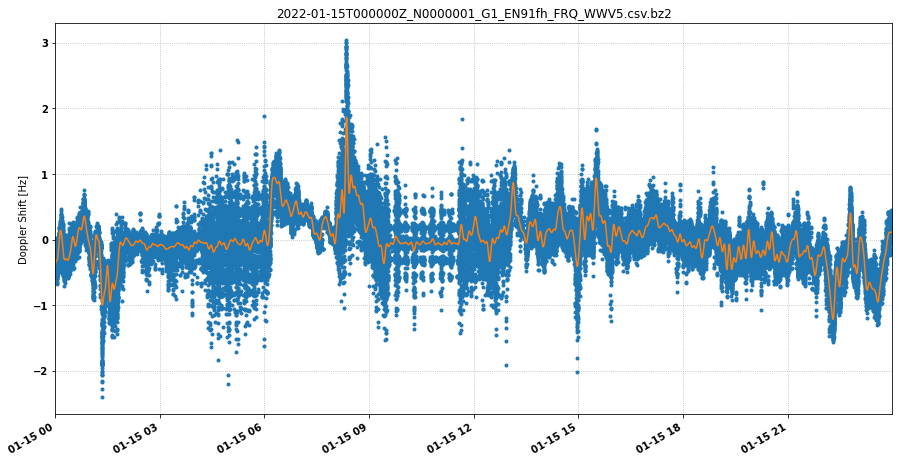

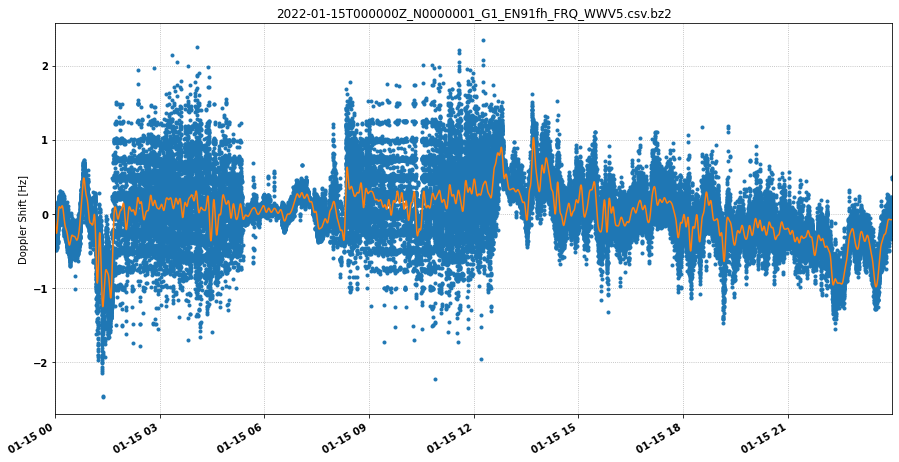

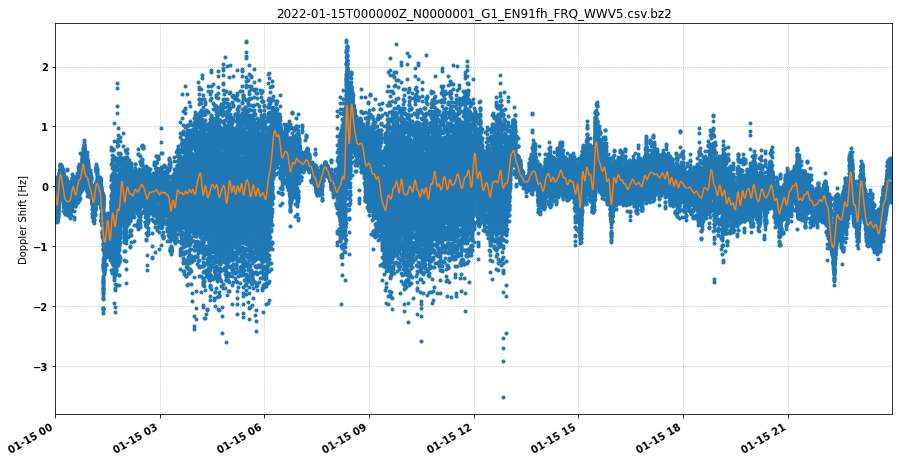

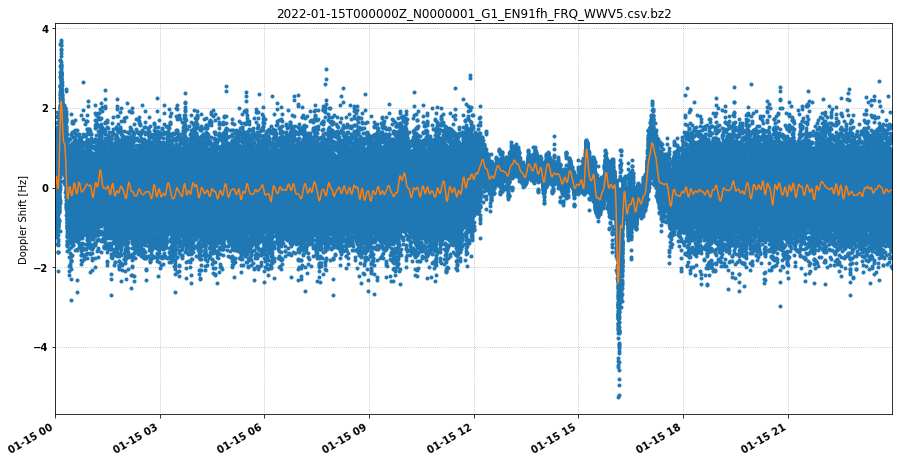

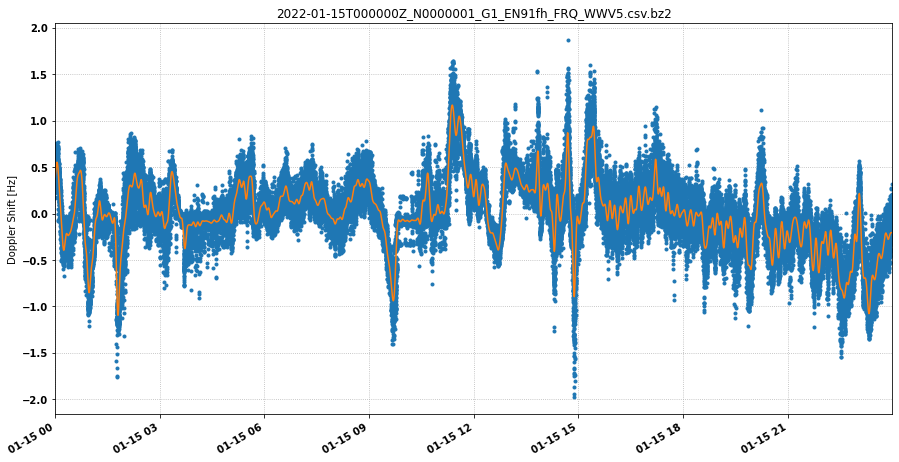

In [25]:
for fpath in fnames:
    df    = pd.read_csv(fpath, comment = '#', parse_dates=[0]) #Load data
    df['Freq'] = df['Freq']-df['Freq'].mean()
    
    # Get Julian Dates for Data Frame
    jd   = [x.to_julian_date() for x in df['UTC']]
    
    # Create the list of datetimes that we want to resample to.

    # Find the start and end times of the array.
    sTime = df['UTC'].min()
    eTime = df['UTC'].max()

    # Break
    sYr  = sTime.year
    sMon = sTime.month
    sDy  = sTime.day
    sHr  = sTime.hour
    sMin = sTime.minute
    sSec = sTime.second
    resample_sTime = datetime.datetime(sYr,sMon,sDy,sHr,sMin,sSec)

    eYr  = eTime.year
    eMon = eTime.month
    eDy  = eTime.day
    eHr  = eTime.hour
    eMin = eTime.minute
    eSec = eTime.second
    resample_eTime = datetime.datetime(eYr,eMon,eDy,eHr,eMin,eSec)

    dt = datetime.timedelta(seconds=1)
    rs_times = [resample_sTime]
    while rs_times[-1] < resample_eTime:
        rs_times.append(rs_times[-1]+dt)

    # Convert to Julian Date
    rs_jd   = [x.to_julian_date() for x in pd.to_datetime(rs_times)]
    
    fn      = interp1d(jd,df['Freq'].values)
    rs_Freq = fn(rs_jd)
    rs_df   = pd.DataFrame({'UTC':rs_times,'Freq':rs_Freq})
    
    FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERORDER=6
    b, a    = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
    rs_df['Freq_1'] = filtfilt(b, a, rs_df['Freq'])
    
    fig = plt.figure(figsize=(15,8))
    ax  = fig.add_subplot(111)
    xx  = rs_df['UTC']
    yy  = rs_df['Freq']
    ax.plot(xx,yy,ls='',marker='.',label='Freq')

    yy  = rs_df['Freq_1']
    ax.plot(xx,yy,label='Freq_1')
    
    fig.autofmt_xdate()
    ax.set_ylabel('Doppler Shift [Hz]')
    ax.set_title(fname)
    plt.show()
    
   # break
    